In [1]:
import torch
import torchvision

import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt

from torch.distributions import Normal
from torch.distributions import kl_divergence

/home/martinr/miniconda3/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/martinr/miniconda3/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZNK3c107SymBool10guard_boolEPKcl'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


# Assignment 1

In [2]:
def mlp_builder(input_dim, output_dim, num_hidden_units):
    prev_dim = input_dim
    modules = []
    for h_dim in num_hidden_units :
        modules.extend([nn.Linear(prev_dim, h_dim), nn.ReLU()])
        prev_dim = h_dim
    modules.append(nn.Linear(prev_dim, output_dim))
    return nn.Sequential(*modules)

mlp_builder(28*28, 64, [256, 256])

Sequential(
  (0): Linear(in_features=784, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): ReLU()
  (4): Linear(in_features=256, out_features=64, bias=True)
)

In [3]:
class Encoder(nn.Module):
    def __init__(self, input_dim, latent_dim, num_hidden_units, min_sigma=1e-6):
        super(Encoder, self).__init__()
        self.latent_dim = latent_dim
        self.body = mlp_builder(input_dim, 2*latent_dim, num_hidden_units)
        self.min_sigma = min_sigma
 
    def forward(self, x):
        params = self.body(x)
        mu, sigma = torch.split(params, self.latent_dim, dim=-1)
        sigma = nn.functional.softplus(sigma) + 1e-6
        return mu, sigma

class Decoder(nn.Module):
    def __init__(self, input_dim, latent_dim, num_hidden_units):
        super(Decoder, self).__init__()
        self.body = mlp_builder(input_dim, latent_dim, num_hidden_units)
 
    def forward(self, x):
        mu = self.body(x)
 
        return mu

In [4]:
class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim, num_hidden_units, px_sigma=0.1):
        super(VAE, self).__init__()

        self.encoder = Encoder(input_dim, latent_dim, num_hidden_units)
        self.decoder = Decoder(latent_dim, input_dim, num_hidden_units[::-1])
        self.prior = Normal(torch.zeros(latent_dim), torch.ones(latent_dim))
        self.px_sigma = px_sigma

    def forward(self, x):
        qz_mu, qz_sigma = self.encoder(x)
        qz = Normal(qz_mu, qz_sigma)

        z = qz.sample()

        x_hat = self.decoder(z)
        return x_hat
    

In [5]:
class Data():
    def __init__(self, batch_size=64):
        # transforms
        transform = transforms.Compose([transforms.ToTensor()])        
        self.train_set = torchvision.datasets.MNIST('data', download=True, train=True, transform=transform)
        # dataloaders

        self.data_loader = torch.utils.data.DataLoader(self.train_set, batch_size=batch_size, shuffle=True, num_workers=0)

In [6]:
def compute_elbo(vae, x):
    qz_mu, qz_sigma = vae.encoder(x)
    qz = Normal(qz_mu, qz_sigma)
    kl_div = kl_divergence(qz, vae.prior)

    zs = qz.rsample()
    
    px_mu = vae.decoder(zs)
    px_sigma = vae.px_sigma*torch.ones_like(px_mu)
    px = Normal(px_mu, px_sigma)
    log_px = px.log_prob(x)
    # print(log_px.shape, kl_div.shape)
    elbo = log_px.sum(-1) - kl_div.sum(-1)
    
    return elbo

def train_vae(vae, data, lr=0.1, epochs=10):
    vae.train()
    optimizer = optim.Adam(vae.parameters(), lr=lr)
    n_samples = len(data.train_set)
    print(f'Number of training datapoints: {n_samples}')
    elbos = []
    
    for epoch in range(epochs):
        current_elbo = 0
        for i, (x, _) in enumerate(data.data_loader):
            optimizer.zero_grad()
            
            # print(x.flatten(-2, -1).squeeze(1).shape)
            elbo = compute_elbo(vae, x.flatten(-2, -1).squeeze(1))
            current_elbo += elbo.detach().cpu().sum()
            elbos.append(elbo.detach().cpu().mean())
            
            loss = -1*elbo.mean()
            
            loss.backward()

            optimizer.step()
        print(f'Epoch {epoch+1} elbo: {current_elbo / n_samples}')
    return elbos
    

def evaluate_elbo(vae, data, sigma=0.01):
    total_elbo = 0
    vae.eval()
    n_samples = len(data.train_set)
    for i, (x, _) in enumerate(data.data_loader):
        elbo = compute_elbo(vae, x.flatten(-2, -1).squeeze(1))
        total_elbo += elbo.detach().cpu().sum().item()
    return total_elbo / n_samples

def ewa(array, q=0.99):
    ewa_array = [array[0]]
    for i in range(1, len(array)):
        ewa_array.append(q * array[i] + (1-q) * ewa_array[-1])
    return np.array(ewa_array)

# Assignment 2 - baseline VAE


In [7]:
from torchvision.utils import make_grid
def visualize_reconstruction(vae, batch_size=16, title='Reconstruction'):
    vae.eval()

    torch.manual_seed(0)
    data = Data(batch_size=batch_size)
    small_batch = next(iter(data.data_loader))[0]

    with torch.no_grad():
        x = small_batch.flatten(-2, -1).squeeze(1)
        x_hat = vae(x)
    reconstr_images = x_hat.reshape(batch_size, 1, 28, 28)

    img = make_grid(torch.cat([small_batch, reconstr_images], dim=0), nrow=batch_size, padding=2, normalize=False)
    plt.figure(figsize=(16,9))
    plt.imshow(img.permute(1,2,0).clamp(0,1.).numpy())
    plt.title(title)
    plt.show()

In [8]:
data = Data(batch_size=64)
epochs = 10
z_dim = 128
vae = VAE(28*28, z_dim, [])
print(vae.encoder, vae.decoder)
elbos = train_vae(vae, data, lr=1e-3, epochs=epochs)

Encoder(
  (body): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
  )
) Decoder(
  (body): Sequential(
    (0): Linear(in_features=128, out_features=784, bias=True)
  )
)
Number of training datapoints: 60000
Epoch 1 elbo: 106.193115234375
Epoch 2 elbo: 552.770751953125
Epoch 3 elbo: 586.6641235351562
Epoch 4 elbo: 601.8475341796875
Epoch 5 elbo: 612.59130859375
Epoch 6 elbo: 620.4312744140625
Epoch 7 elbo: 626.7928466796875
Epoch 8 elbo: 631.8424682617188
Epoch 9 elbo: 635.1976928710938
Epoch 10 elbo: 638.0170288085938


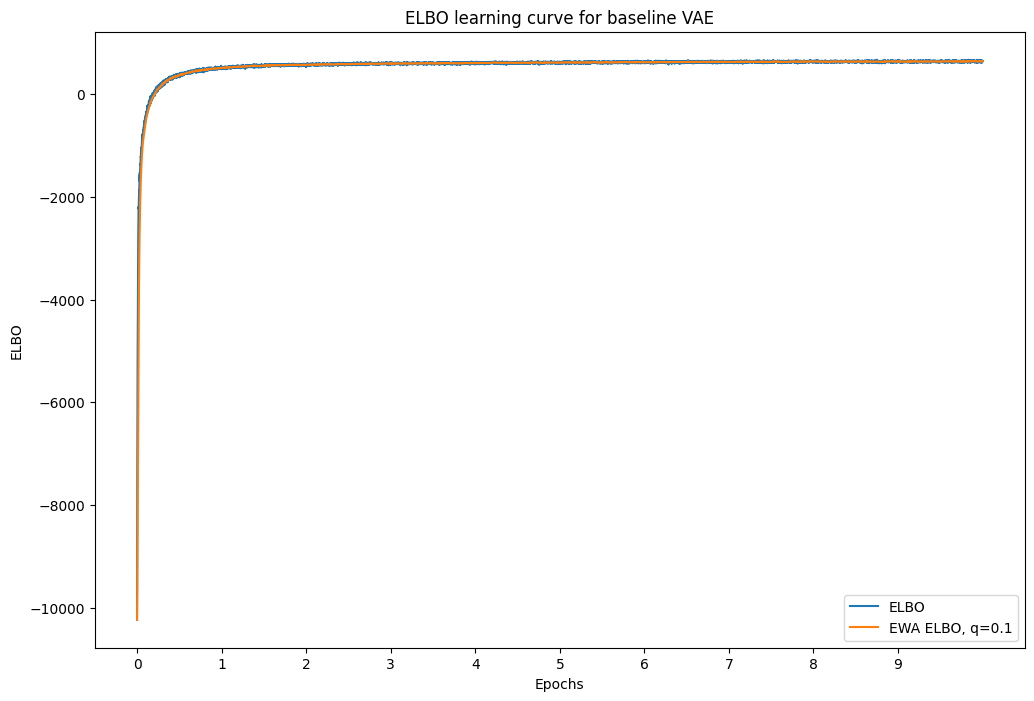

In [9]:
plt.figure(figsize=(12,8))
plt.plot(elbos, label='ELBO')
q=0.1
plt.plot(ewa(elbos, q=q), label= f'EWA ELBO, q={q}')
plt.xlabel('Epochs')
plt.ylabel('ELBO')
plt.title('ELBO learning curve for baseline VAE')
ticks = np.arange(0, len(elbos), len(elbos)//epochs)
plt.xticks(ticks, labels=list(map(str, range(len(ticks)))))
plt.legend()
plt.show()

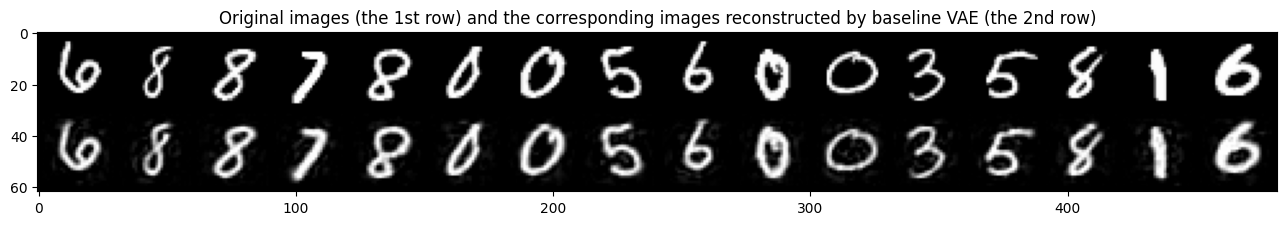

In [10]:
visualize_reconstruction(vae, title='Original images (the 1st row) and the corresponding images reconstructed by baseline VAE (the 2nd row)')

In [11]:
encoder_params = sum(p.numel() for p in vae.encoder.parameters() if p.requires_grad)
decoder_params = sum(p.numel() for p in vae.decoder.parameters() if p.requires_grad)
print(f"Baseline VAE encoder has {encoder_params} parameters and corresponding decoder has {decoder_params} paramenters.")

Baseline VAE encoder has 200960 parameters and corresponding decoder has 101136 paramenters.


# Assignment 2 - deeper VAE

In [12]:
data = Data(batch_size=64)
epochs = 10
z_dim = 128
vae_deeper = VAE(28*28, z_dim, [256, 256]) 
elbos_deeper = train_vae(vae_deeper, data, lr=1e-3, epochs=epochs)

Number of training datapoints: 60000
Epoch 1 elbo: -339.0941467285156
Epoch 2 elbo: 237.6863555908203
Epoch 3 elbo: 390.8161315917969
Epoch 4 elbo: 467.13360595703125
Epoch 5 elbo: 512.3118896484375
Epoch 6 elbo: 545.0195922851562
Epoch 7 elbo: 568.4536743164062
Epoch 8 elbo: 585.8687133789062
Epoch 9 elbo: 601.097412109375
Epoch 10 elbo: 612.9813232421875


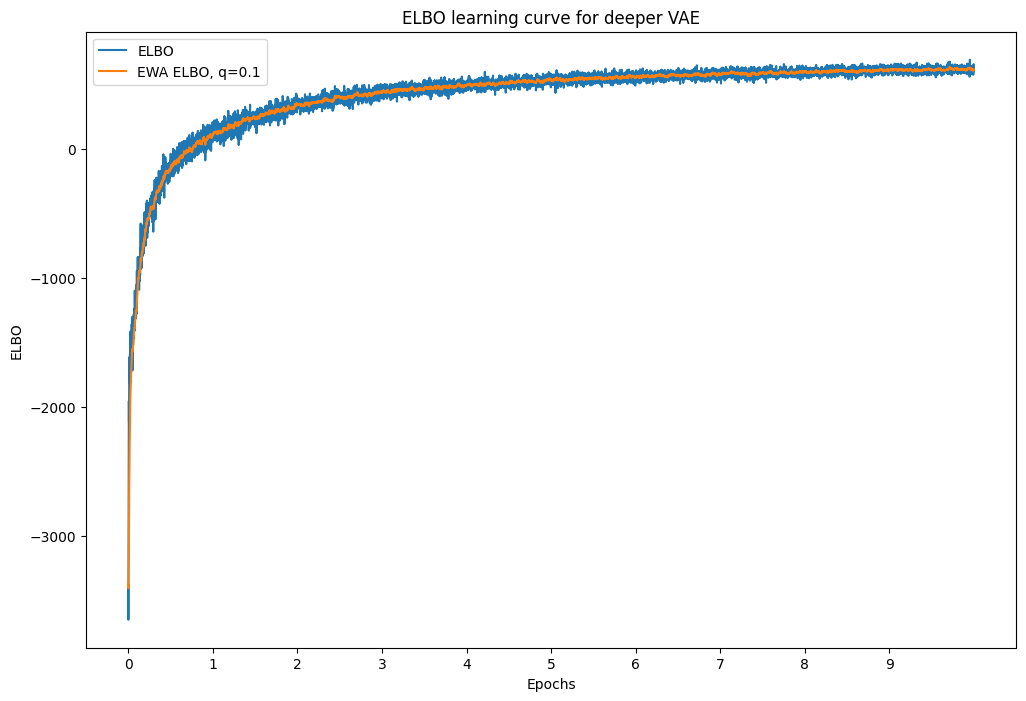

In [13]:
plt.figure(figsize=(12,8))
plt.plot(elbos_deeper, label='ELBO')
q=0.1
plt.plot(ewa(elbos_deeper, q=q), label= f'EWA ELBO, q={q}')
plt.xlabel('Epochs')
plt.ylabel('ELBO')
plt.title('ELBO learning curve for deeper VAE')
ticks = np.arange(0, len(elbos_deeper), len(elbos_deeper)//epochs)
plt.xticks(ticks, labels=list(map(str, range(len(ticks)))))
plt.legend()
plt.show()

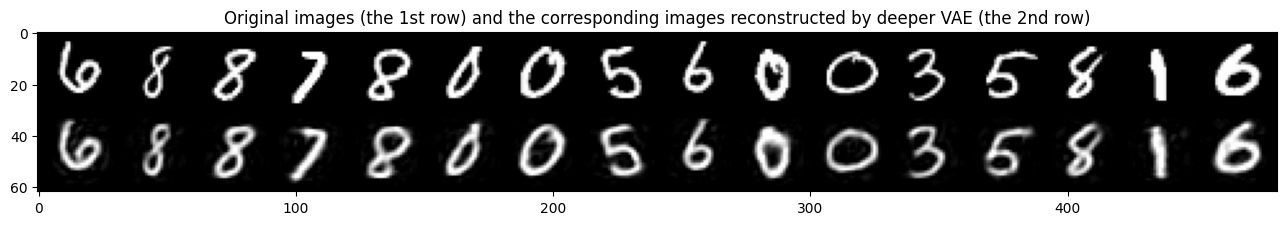

In [14]:
visualize_reconstruction(vae_deeper, title='Original images (the 1st row) and the corresponding images reconstructed by deeper VAE (the 2nd row)')

In [15]:
deeper_encoder_params = sum(p.numel() for p in vae_deeper.encoder.parameters() if p.requires_grad)
deeper_decoder_params = sum(p.numel() for p in vae_deeper.decoder.parameters() if p.requires_grad)
print(f"Deeper VAE encoder has {deeper_encoder_params} parameters and corresponding decoder has {deeper_decoder_params} paramenters.")

Deeper VAE encoder has 332544 parameters and corresponding decoder has 300304 paramenters.


# Assignment 3 - ELBO

In [16]:
final_elbo = round(evaluate_elbo(vae, data), 2)
final_elbo_deeper = round(evaluate_elbo(vae_deeper, data), 2)
print(final_elbo, final_elbo_deeper)

639.55 623.37


Baseline VAE achieved ELBO of ELBO of -132.93 and deeper VAE achieved the VAE of -88.61. Both networks were trained using Adam optimizer with default parameters and learning rate $10^{-4}$. Starndard deviation $\sigma$ used for each component of $p_{\theta}(x|z)$ was 0.01 for both VAEs.

# Assignment 3 - Posterior collapse

In [17]:
def posterior_collapse_metric(vae, batch_size=512, title='title'):
    vae.eval()
    torch.manual_seed(0)
    data = Data(batch_size=batch_size)
    small_batch = next(iter(data.data_loader))[0]
    
    qz_mu, qz_sigma = vae.encoder(small_batch.flatten(-2, -1).squeeze(1))
    qz = Normal(qz_mu, qz_sigma)
    
    kl_div = torch.distributions.kl_divergence(qz, vae.prior)

    kl_div_avg = kl_div.mean(dim=0).squeeze(0)
    plt.hist(kl_div_avg.detach().numpy())
    plt.ylabel('Number of components')
    plt.xlabel('Averaged KL-divergence')
    plt.title(title)
    plt.show()

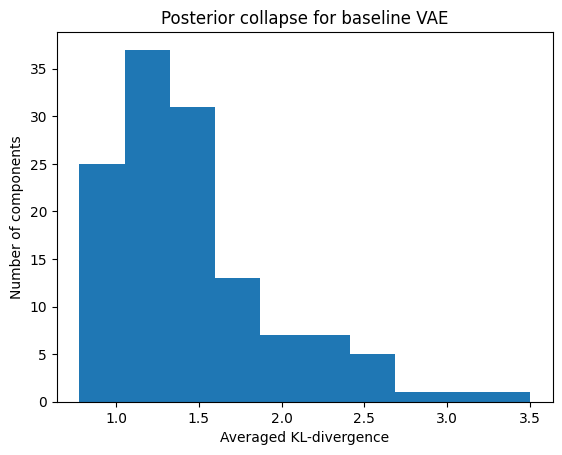

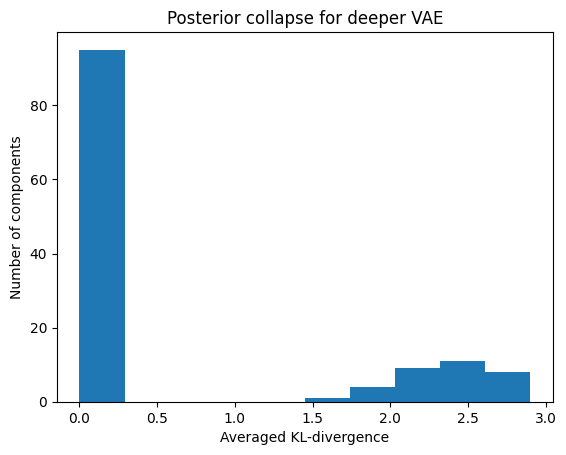

In [18]:
posterior_collapse_metric(vae, title='Posterior collapse for baseline VAE')
posterior_collapse_metric(vae_deeper, title='Posterior collapse for deeper VAE')

# Assignment 3 - Evaluating the decoder

In [19]:
def evaluate_decoder(vae, zdim=128, batch_size=64, title='title'):
    vae.eval()
    torch.manual_seed(0)
    pz = vae.prior
    zs = pz.sample((batch_size, ))
    # print(zs.shape)
    mu = vae.decoder(zs)
    reconstr_images = mu.reshape(batch_size, 1, 28, 28)
    
    img = make_grid(reconstr_images, nrow=8, padding=1, pad_value=1., normalize=False)
    plt.figure(figsize=(16,9))
    plt.imshow(img.permute(1,2,0).clamp(0,1.).numpy())
    plt.show()
    

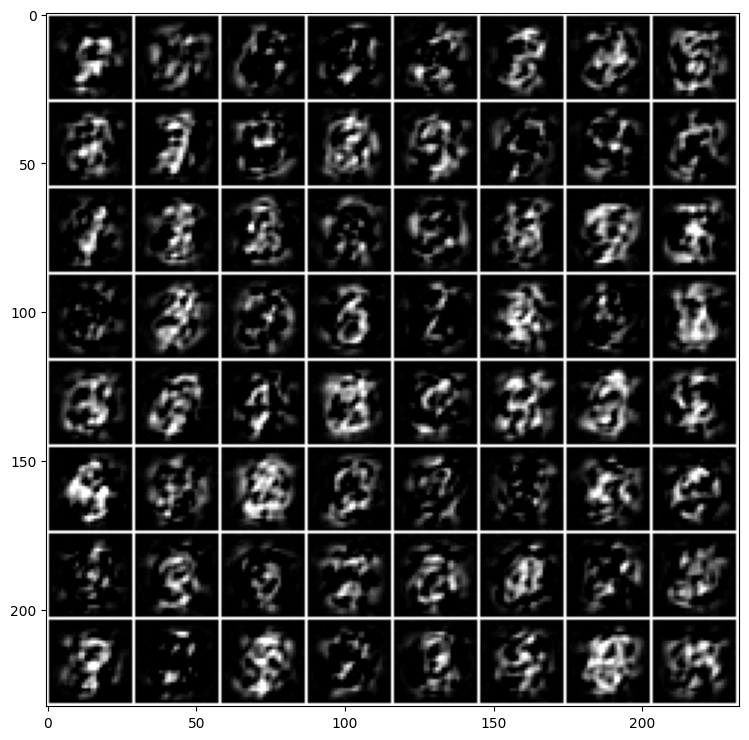

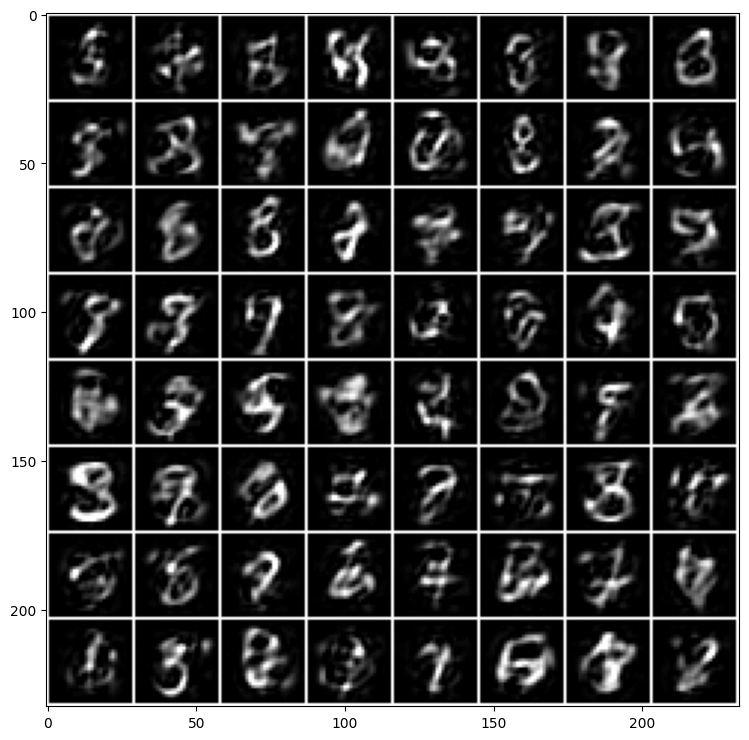

In [20]:
evaluate_decoder(vae, title='Evaluating the decoder for the baseline VAE')
evaluate_decoder(vae_deeper, title='Evaluating the decoder for the deeper VAE')

# Assignment 4 - Limiting the distribution

In [21]:
import cv2
def limiting_distribution(vae, fname='title', batch_size=64, n_frames=100):
    vae.eval()
    torch.manual_seed(0)
    
    pz = vae.prior
    zs = pz.sample((batch_size, ))
    
    images = []
    
    for i in range(n_frames):
        # decode
        px_mu = vae.decoder(zs)
        mu = px_mu.reshape(batch_size, 1, 28, 28)
        
        # create image 
        grid = make_grid(mu, nrow=8, padding=1, pad_value=1.)
        image = grid.permute(1,2,0).clamp(0,1.).numpy()
        images.append(image) 
        
        px_sigma = vae.px_sigma*torch.ones_like(px_mu)
        px = Normal(px_mu, px_sigma)
        
        # sample
        x_hat = px.sample()
        
        # encode
        qz_mu, qz_sigma = vae.encoder(x_hat)
        qz = Normal(qz_mu, qz_sigma)
        zs = qz.sample()
 
    # inspired by https://theailearner.com/2018/10/15/creating-video-from-images-using-opencv-python/
    size = images[0].shape[:2]
    out = cv2.VideoWriter(f'{fname}.mp4',cv2.VideoWriter_fourcc(*'MP4V'), 10, size)
 
    for image in images:
        # print(image.shape)
        out.write((image*255).astype(np.uint8))
    out.release()
    

In [22]:
limiting_distribution(vae, fname='baseline_vae')
limiting_distribution(vae_deeper, fname='deeper_vae')

OpenCV: FFMPEG: tag 0x5634504d/'MP4V' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'
OpenCV: FFMPEG: tag 0x5634504d/'MP4V' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'
